# Data Preparation

In [ ]:
#Import package
import pandas as pd


In [ ]:
# Import data
buku = pd.read_csv("https://raw.githubusercontent.com/aldizzaldi/melawanBurnout/master/dataset/books.csv")

In [ ]:
buku.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


# EDA

In [ ]:
buku.describe()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn13,original_publication_year,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
count,10000.00000,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,9.415000e+03,9979.000000,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,1.000000e+04
mean,5000.50000,5.264697e+06,5.471214e+06,8.646183e+06,75.712700,9.755044e+12,1981.987674,4.002191,5.400124e+04,5.968732e+04,2919.955300,1345.040600,3110.885000,11475.893800,1.996570e+04,2.378981e+04
std,2886.89568,7.575462e+06,7.827330e+06,1.175106e+07,170.470728,4.428619e+11,152.576665,0.254427,1.573700e+05,1.678038e+05,6124.378132,6635.626263,9717.123578,28546.449183,5.144736e+04,7.976889e+04
min,1.00000,1.000000e+00,1.000000e+00,8.700000e+01,1.000000,1.951703e+08,-1750.000000,2.470000,2.716000e+03,5.510000e+03,3.000000,11.000000,30.000000,323.000000,7.500000e+02,7.540000e+02
25%,2500.75000,4.627575e+04,4.791175e+04,1.008841e+06,23.000000,9.780316e+12,1990.000000,3.850000,1.356875e+04,1.543875e+04,694.000000,196.000000,656.000000,3112.000000,5.405750e+03,5.334000e+03
50%,5000.50000,3.949655e+05,4.251235e+05,2.719524e+06,40.000000,9.780452e+12,2004.000000,4.020000,2.115550e+04,2.383250e+04,1402.000000,391.000000,1163.000000,4894.000000,8.269500e+03,8.836000e+03
75%,7500.25000,9.382225e+06,9.636112e+06,1.451775e+07,67.000000,9.780831e+12,2011.000000,4.180000,4.105350e+04,4.591500e+04,2744.250000,885.000000,2353.250000,9287.000000,1.602350e+04,1.730450e+04
max,10000.00000,3.328864e+07,3.553423e+07,5.639960e+07,3455.000000,9.790008e+12,2017.000000,4.820000,4.780653e+06,4.942365e+06,155254.000000,456191.000000,436802.000000,793319.000000,1.481305e+06,3.011543e+06


Cek apakah ada empty/missing value

In [ ]:
buku.isna().sum()

book_id                         0
goodreads_book_id               0
best_book_id                    0
work_id                         0
books_count                     0
isbn                          700
isbn13                        585
authors                         0
original_publication_year      21
original_title                585
title                           0
language_code                1084
average_rating                  0
ratings_count                   0
work_ratings_count              0
work_text_reviews_count         0
ratings_1                       0
ratings_2                       0
ratings_3                       0
ratings_4                       0
ratings_5                       0
image_url                       0
small_image_url                 0
dtype: int64

## Melengkapi original_publication_year

In [ ]:
missing_pubyear_id = buku[buku['original_publication_year'].isna()]['goodreads_book_id'].tolist()
missing_pubyear_id

[3609760,
 90072,
 856917,
 36,
 8724779,
 349254,
 9832370,
 5171894,
 17733861,
 1044141,
 9748274,
 48811,
 9528186,
 809849,
 765148,
 197436,
 351023,
 11318,
 6054190,
 1056627,
 6614886]

In [ ]:
import requests
from bs4 import BeautifulSoup
import re

Ambil aja dari Goodreads, tapi enggak 100% yakin itu *original* publication year-nya. Gapapa lah.

In [ ]:
def get_pub_year(i):
    url = f"https://www.goodreads.com/book/show/{i}"
    html_page = requests.get(url)
    soup = BeautifulSoup(html_page.content, 'html.parser')
    try:
        pub_text = soup.select('div.row')[1].text.strip()
        pub_year = int(re.search(r'\d{4}', pub_text).group(0))
    except:
        pub_year = ''

    return pub_year

In [ ]:
pub_year = []
for id in missing_pubyear_id:
  pub_year.append(get_pub_year(id))
pub_year

[2008,
 1998,
 2006,
 2003,
 2009,
 2003,
 2010,
 2009,
 2013,
 2004,
 2010,
 2006,
 2010,
 2007,
 2001,
 2000,
 2004,
 1988,
 2009,
 2007,
 2009]

In [ ]:
buku.loc[buku['original_publication_year'].isna(), 'original_publication_year'] = pub_year
buku['original_publication_year'].isna().any()

False

## Melengkapi original title (dan isbn13?)

In [ ]:
buku.isna().sum()

book_id                         0
goodreads_book_id               0
best_book_id                    0
work_id                         0
books_count                     0
isbn                          700
isbn13                        585
authors                         0
original_publication_year       0
original_title                585
title                           0
language_code                1084
average_rating                  0
ratings_count                   0
work_ratings_count              0
work_text_reviews_count         0
ratings_1                       0
ratings_2                       0
ratings_3                       0
ratings_4                       0
ratings_5                       0
image_url                       0
small_image_url                 0
dtype: int64

Jumlah missing values `original_title` dan `isbn` sama, jadi mungkin berasal dari rows yang sama pula.

In [ ]:
missing_ori_title = buku.loc[buku['original_title'].isna(), :].goodreads_book_id
missing_ori_title

74        227443
142     18143977
209       345627
214      9969571
256        13023
          ...   
9942      653559
9944    18943009
9956     6332526
9957     7494887
9970    12602078
Name: goodreads_book_id, Length: 585, dtype: int64

In [ ]:
missing_isbn13 = buku.loc[buku['isbn13'].isna(), :].goodreads_book_id
missing_isbn13

105      9418327
120         7604
161        49552
187     10664113
202     11505797
          ...   
9928     6614886
9944    18943009
9958    13178410
9966     5295735
9970    12602078
Name: goodreads_book_id, Length: 585, dtype: int64

Ouh, ternyata lumayan beda. Oke, selesaikan terpisah.

In [ ]:
missing_ori_title = missing_ori_title.to_list()

In [ ]:
def get_ori_title(i):
  url = f"https://www.goodreads.com/book/show/{i}"
  headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
  html_page = requests.Session().get(url, headers=headers)
  soup = BeautifulSoup(html_page.content, 'html.parser')
  try:
      ori_title = soup.select('.infoBoxRowItem')[0].text.strip()
  except:
      ori_title = None
      
  return ori_title

585 kebanyakan? Saatnya threading!

In [ ]:
import concurrent.futures
import time
from tqdm import tqdm

In [ ]:
while buku['original_title'].isna().sum() > 0:
  missing_ori_title = buku.loc[buku['original_title'].isna(), :].goodreads_book_id.to_list()
  found_ori_title = ['' for x in missing_ori_title]

  with concurrent.futures.ThreadPoolExecutor() as executor:
    # with concurrent.futures.ThreadPoolExecutor() as executor:
    #   future = executor.map(get_songs, alphabets)
    #   songs_kapanlagi = [song for f in future for song in f]

    future = executor.map(get_ori_title, missing_ori_title)
    for i,f in enumerate(tqdm(future, total=len(missing_ori_title))):
      found_ori_title[i] = f
      time.sleep(1e-3)

  buku.loc[buku['original_title'].isna(), 'original_title'] = found_ori_title

  print(len(found_ori_title))
  print(buku['original_title'].isna().sum())

  0%|          | 0/517 [00:00<?, ?it/s]

585
517


  0%|          | 0/496 [00:00<?, ?it/s]

517
496


  0%|          | 0/471 [00:00<?, ?it/s]

496
471


  0%|          | 0/443 [00:00<?, ?it/s]

471
443


  0%|          | 0/414 [00:00<?, ?it/s]

443
414


  0%|          | 0/400 [00:00<?, ?it/s]

414
400


  0%|          | 0/390 [00:00<?, ?it/s]

400
390


  0%|          | 0/366 [00:00<?, ?it/s]

390
366


  0%|          | 0/351 [00:00<?, ?it/s]

366
351


  0%|          | 0/336 [00:00<?, ?it/s]

351
336


  0%|          | 0/321 [00:00<?, ?it/s]

336
321


  0%|          | 0/306 [00:00<?, ?it/s]

321
306


  0%|          | 0/293 [00:00<?, ?it/s]

306
293


  0%|          | 0/277 [00:00<?, ?it/s]

293
277


  0%|          | 0/267 [00:00<?, ?it/s]

277
267


  0%|          | 0/258 [00:00<?, ?it/s]

267
258


  0%|          | 0/248 [00:00<?, ?it/s]

258
248


  0%|          | 0/237 [00:00<?, ?it/s]

248
237


  0%|          | 0/225 [00:00<?, ?it/s]

237
225


  0%|          | 0/214 [00:00<?, ?it/s]

225
214


  0%|          | 0/200 [00:00<?, ?it/s]

214
200


  0%|          | 0/186 [00:00<?, ?it/s]

200
186


  0%|          | 0/179 [00:00<?, ?it/s]

186
179


  0%|          | 0/172 [00:00<?, ?it/s]

179
172


  0%|          | 0/164 [00:00<?, ?it/s]

172
164


  0%|          | 0/151 [00:00<?, ?it/s]

164
151


  0%|          | 0/141 [00:00<?, ?it/s]

151
141


  0%|          | 0/136 [00:00<?, ?it/s]

141
136


  0%|          | 0/129 [00:00<?, ?it/s]

136
129


  0%|          | 0/118 [00:00<?, ?it/s]

129
118


  0%|          | 0/110 [00:00<?, ?it/s]

118
110


  0%|          | 0/102 [00:00<?, ?it/s]

110
102


  0%|          | 0/93 [00:00<?, ?it/s]

102
93


  0%|          | 0/90 [00:00<?, ?it/s]

93
90


  0%|          | 0/89 [00:00<?, ?it/s]

90
89


  0%|          | 0/83 [00:00<?, ?it/s]

89
83


  0%|          | 0/72 [00:00<?, ?it/s]

83
72


  0%|          | 0/67 [00:00<?, ?it/s]

72
67


  0%|          | 0/63 [00:00<?, ?it/s]

67
63


  0%|          | 0/60 [00:00<?, ?it/s]

63
60


  0%|          | 0/58 [00:00<?, ?it/s]

60
58


  0%|          | 0/56 [00:00<?, ?it/s]

58
56


  0%|          | 0/55 [00:00<?, ?it/s]

56
55


  0%|          | 0/55 [00:00<?, ?it/s]

55
55


  0%|          | 0/54 [00:00<?, ?it/s]

55
54


  0%|          | 0/52 [00:00<?, ?it/s]

54
52


  0%|          | 0/47 [00:00<?, ?it/s]

52
47


  0%|          | 0/43 [00:00<?, ?it/s]

47
43


  0%|          | 0/41 [00:00<?, ?it/s]

43
41


  0%|          | 0/38 [00:00<?, ?it/s]

41
38


  0%|          | 0/35 [00:00<?, ?it/s]

38
35


  0%|          | 0/33 [00:00<?, ?it/s]

35
33


  0%|          | 0/32 [00:00<?, ?it/s]

33
32


  0%|          | 0/32 [00:00<?, ?it/s]

32
32


  0%|          | 0/32 [00:00<?, ?it/s]

32
32


  0%|          | 0/32 [00:00<?, ?it/s]

32
32


  0%|          | 0/30 [00:00<?, ?it/s]

32
30


  0%|          | 0/29 [00:00<?, ?it/s]

30
29


  0%|          | 0/29 [00:00<?, ?it/s]

29
29


  0%|          | 0/27 [00:00<?, ?it/s]

29
27


  0%|          | 0/27 [00:00<?, ?it/s]

27
27


  0%|          | 0/25 [00:00<?, ?it/s]

27
25


  0%|          | 0/24 [00:00<?, ?it/s]

25
24


  0%|          | 0/21 [00:00<?, ?it/s]

24
21


  0%|          | 0/19 [00:00<?, ?it/s]

21
19


  0%|          | 0/18 [00:00<?, ?it/s]

19
18


  0%|          | 0/18 [00:00<?, ?it/s]

18
18


  0%|          | 0/18 [00:00<?, ?it/s]

18
18


  0%|          | 0/18 [00:00<?, ?it/s]

18
18


  0%|          | 0/17 [00:00<?, ?it/s]

18
17


  0%|          | 0/16 [00:00<?, ?it/s]

17
16


  0%|          | 0/14 [00:00<?, ?it/s]

16
14


  0%|          | 0/14 [00:00<?, ?it/s]

14
14


  0%|          | 0/14 [00:00<?, ?it/s]

14
14


  0%|          | 0/14 [00:00<?, ?it/s]

14
14


  0%|          | 0/14 [00:00<?, ?it/s]

14
14


  0%|          | 0/14 [00:00<?, ?it/s]

14
14


  0%|          | 0/13 [00:00<?, ?it/s]

14
13


  0%|          | 0/12 [00:00<?, ?it/s]

13
12


  0%|          | 0/12 [00:00<?, ?it/s]

12
12


  0%|          | 0/12 [00:00<?, ?it/s]

12
12


  0%|          | 0/12 [00:00<?, ?it/s]

12
12


  0%|          | 0/11 [00:00<?, ?it/s]

12
11


  0%|          | 0/11 [00:00<?, ?it/s]

11
11


  0%|          | 0/9 [00:00<?, ?it/s]

11
9


  0%|          | 0/9 [00:00<?, ?it/s]

9
9


  0%|          | 0/8 [00:00<?, ?it/s]

9
8


  0%|          | 0/8 [00:00<?, ?it/s]

8
8


  0%|          | 0/8 [00:00<?, ?it/s]

8
8


  0%|          | 0/7 [00:00<?, ?it/s]

8
7


  0%|          | 0/6 [00:00<?, ?it/s]

7
6


  0%|          | 0/6 [00:00<?, ?it/s]

6
6


  0%|          | 0/6 [00:00<?, ?it/s]

6
6


  0%|          | 0/4 [00:00<?, ?it/s]

6
4


  0%|          | 0/4 [00:00<?, ?it/s]

4
4


  0%|          | 0/4 [00:00<?, ?it/s]

4
4


  0%|          | 0/4 [00:00<?, ?it/s]

4
4


  0%|          | 0/4 [00:00<?, ?it/s]

4
4


  0%|          | 0/4 [00:00<?, ?it/s]

4
4


  0%|          | 0/4 [00:00<?, ?it/s]

4
4


  0%|          | 0/4 [00:00<?, ?it/s]

4
4


  0%|          | 0/4 [00:00<?, ?it/s]

4
4


  0%|          | 0/4 [00:00<?, ?it/s]

4
4


  0%|          | 0/3 [00:00<?, ?it/s]

4
3


  0%|          | 0/3 [00:00<?, ?it/s]

3
3


  0%|          | 0/3 [00:00<?, ?it/s]

3
3


  0%|          | 0/2 [00:00<?, ?it/s]

3
2


  0%|          | 0/2 [00:00<?, ?it/s]

2
2


  0%|          | 0/2 [00:00<?, ?it/s]

2
2


  0%|          | 0/1 [00:00<?, ?it/s]

2
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1


100%|██████████| 1/1 [00:05<00:00,  5.28s/it]

1
0


In [ ]:
buku.to_csv('buku_v2.csv', index=False)

from google.colab import files
files.download( 'buku_v2.csv' )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
missing_isbn13 = missing_isbn13.to_list()

In [ ]:
missing_isbn13[:5]

[9418327, 7604, 49552, 10664113, 11505797]

In [ ]:
def get_isbn13(i):
  url = f"https://www.goodreads.com/book/show/{i}"
  headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
  html_page = requests.Session().get(url, headers=headers)
  soup = BeautifulSoup(html_page.content, 'html.parser')
  try:
      isbn13 = soup.select('span', itemprop='isbn')
  except:
      isbn13 = None
      
  return isbn13

get_isbn13(missing_isbn13[2])

In [ ]:
while buku['isbn13'].isna().sum() > 0:
  missing_ori_title = buku.loc[buku['isbn13'].isna(), :].goodreads_book_id.to_list()
  found_ori_title = ['' for x in missing_ori_title]

  with concurrent.futures.ThreadPoolExecutor() as executor:
    # with concurrent.futures.ThreadPoolExecutor() as executor:
    #   future = executor.map(get_songs, alphabets)
    #   songs_kapanlagi = [song for f in future for song in f]

    future = executor.map(get_ori_title, missing_ori_title)
    for i,f in enumerate(tqdm(future, total=len(missing_ori_title))):
      found_ori_title[i] = f
      time.sleep(1e-3)

  buku.loc[buku['original_title'].isna(), 'original_title'] = found_ori_title

  print(len(found_ori_title))
  print(buku['original_title'].isna().sum())

Ternyata emang enggak semua buku ada isbn13-nya :/

Oke, bisa diabaikan.

In [ ]:
buku.isna().sum()

In [ ]:
buku[buku.language_code.isna()].goodreads_book_id.tolist()

In [1]:
#Import Data Ratings
import pandas as pd
rating=pd.read_csv("https://raw.githubusercontent.com/rahshabrina/goodbooks-10k/master/ratings.csv")

In [2]:
rating.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [3]:
rating.isna().any()

user_id    False
book_id    False
rating     False
dtype: bool

# Modelling

In [4]:
#Splitting Data

from sklearn.model_selection import train_test_split
Xtrain, Xtest = train_test_split(rating, test_size=0.2, random_state=1)
print(f"Shape of train data: {Xtrain.shape}")
print(f"Shape of test data: {Xtest.shape}")

Shape of train data: (4781183, 3)
Shape of test data: (1195296, 3)


In [5]:
#Find the number of uniq items
nbook_id = rating.book_id.nunique()
nuser_id = rating.user_id.nunique()

In [6]:
#Embedding

import tensorflow.keras as tf
#Book input network
input_books = tf.layers.Input(shape=[1])
embed_books = tf.layers.Embedding(nbook_id + 1,15)(input_books)
books_out = tf.layers.Flatten()(embed_books)

#user input network
input_users = tf.layers.Input(shape=[1])
embed_users = tf.layers.Embedding(nuser_id + 1,15)(input_users)
users_out = tf.layers.Flatten()(embed_users)

conc_layer = tf.layers.Concatenate()([books_out, users_out])
x = tf.layers.Dense(128, activation='relu')(conc_layer)
x_out = x = tf.layers.Dense(1, activation='relu')(x)
model = tf.Model([input_books, input_users], x_out)

In [7]:
opt = tf.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mean_squared_error')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 15)        150015      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 15)        801375      input_2[0][0]                    
______________________________________________________________________________________________

In [8]:
hist = model.fit([Xtrain.book_id, Xtrain.user_id], Xtrain.rating, 
                 batch_size=64, 
                 epochs=12, 
                 verbose=1,
                 validation_data=([Xtest.book_id, Xtest.user_id], Xtest.rating))

Epoch 1/12
74706/74706 [==============================] - 1073s 14ms/step - loss: 0.9230 - val_loss: 0.7308
Epoch 2/12
74706/74706 [==============================] - 1112s 15ms/step - loss: 0.7125 - val_loss: 0.7065
Epoch 3/12
74706/74706 [==============================] - 1112s 15ms/step - loss: 0.6714 - val_loss: 0.6896
Epoch 4/12
74706/74706 [==============================] - 1108s 15ms/step - loss: 0.6462 - val_loss: 0.6815
Epoch 5/12
74706/74706 [==============================] - 1231s 16ms/step - loss: 0.6253 - val_loss: 0.6815
Epoch 6/12
74706/74706 [==============================] - 1193s 16ms/step - loss: 0.6079 - val_loss: 0.6792
Epoch 7/12
74706/74706 [==============================] - 1276s 17ms/step - loss: 0.5935 - val_loss: 0.6792
Epoch 8/12
74706/74706 [==============================] - 1357s 18ms/step - loss: 0.5817 - val_loss: 0.6804
Epoch 9/12
74706/74706 [==============================] - 1309s 18ms/step - loss: 0.5711 - val_loss: 0.6837
Epoch 10/12
74706/74706 [===

# Evaluating

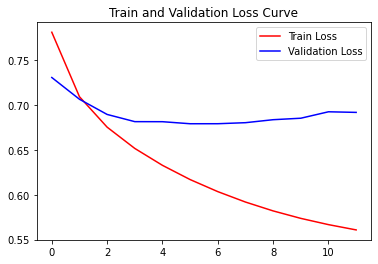

In [9]:
import matplotlib.pyplot as plt

train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

In [10]:
#save the model
model.save('model')

INFO:tensorflow:Assets written to: model\assets


# Deployment

In [ ]:
#xixiix